In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd 
import cv2
import json
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet169, DenseNet121
import efficientnet.tfkeras as efn
print('tensorflow version:', tf.__version__)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      '| device num:', os.environ['CUDA_VISIBLE_DEVICES'])
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), 'physical GPUs,', len(logical_gpus), 'logical GPUs')
    except RuntimeError as e:
        print(e)

tensorflow version: 1.14.0
available GPU devices: 1 | device num: 0
1 physical GPUs, 1 logical GPUs


In [2]:
from tensorflow.keras.utils import get_custom_objects
class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'
def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))
get_custom_objects().update({'Mish': Mish(mish)})

In [3]:
DATA_PATH = './data'
MODELS_PATH = './keras_models'
IMG_SIZE = 112 #224=B0 240=B1 260=B2 300=B3 380=B4 456=B5
SEQ_LEN = 12
BATCH_SIZE = 12
MDL_VERSION = 'v2'
TIFF = -1
RESIZE = None
SEED = 80
#169 8 6 1 2 => 0.7317
#112 8 16 -1 None => 0.7398 maxpool3d
#96 10 16 -1 None => 0.7369 lstm256
#64 12 24 -1 2 => 0.6850 maxpool3d B0
#112 12 12 -1 None => 0.7623 maxpool3d B0 dense 512 128 dropout .4
#120 10 10 -1 None => 0.7520 maxpool3d B1 dense 512 128 dropout .4
#120 10 10 -1 None => 0.7568 maxpool3d B1 dense 512 128 dropout .4 Mish
#112 12 12 -1 None => 0.7690 maxpool3d B0 dense 512 128 dropout .4 Mish
print('96x96x16 size:', 96 * 96 * 16)
print('96x96x25 size:', 96 * 96 * 25)
print('128x128x12 size:', 128 * 128 * 12)
print('154x154x10 size:', 154 * 154 * 10)
print('current size:', IMG_SIZE * IMG_SIZE * SEQ_LEN)

96x96x16 size: 147456
96x96x25 size: 230400
128x128x12 size: 196608
154x154x10 size: 237160
current size: 150528


In [4]:
train = pd.read_csv('{}/train.csv'.format(DATA_PATH))
print('train: ', train.shape, '| unique ids:', sum(train['isup_grade'].value_counts()))

train:  (10616, 4) | unique ids: 10616


In [5]:
def enhance_image(image, contrast=1, brightness=15):
    img_enhanced = cv2.addWeighted(image, contrast, image, 0, brightness)
    return img_enhanced
def get_axis_max_min(array, axis=0):
    one_axis = list((array != 255).sum(axis=tuple([x for x in (0, 1, 2) if x != axis])))
    axis_min = next((i for i, x in enumerate(one_axis) if x), 0)
    axis_max = len(one_axis) - next((i for i, x in enumerate(one_axis[::-1]) if x), 0)
    return axis_min, axis_max

In [6]:
class DataGenPanda(Sequence):
    def __init__(self, imgs_path, df, batch_size=32, 
                 mode='fit', shuffle=False, aug=None,
                 tiff=-1, resize=None,
                 seq_len=12, img_size=128, n_classes=6):
        self.imgs_path = imgs_path
        self.df = df
        self.shuffle = shuffle
        self.mode = mode
        self.aug = aug
        self.tiff = tiff
        self.resize = resize
        self.batch_size = batch_size
        self.img_size = img_size
        self.seq_len = seq_len
        self.n_classes = n_classes
        self.side = int(seq_len ** .5)
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        X = np.zeros((self.batch_size, self.seq_len, self.img_size, self.img_size, 3), dtype=np.float32)
        imgs_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['image_id'].values
        for i, img_name in enumerate(imgs_batch):
            img_path = '{}/{}.tiff'.format(self.imgs_path, img_name)
            img_patches = self.get_patches(img_path)
            X[i, ] = img_patches
        if self.mode == 'fit':
            y = np.zeros((self.batch_size, self.n_classes), dtype=np.float32)
            #y = np.zeros(self.batch_size, dtype=np.int16)
            lbls_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['isup_grade'].values
            for i in range(self.batch_size):
                y[i, lbls_batch[i]] = 1
                #y[i] = lbls_batch[i]
            return X, y
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('mode parameter error')
    def get_patches(self, img_path):
        num_patches = self.seq_len
        p_size = self.img_size
        img = skimage.io.MultiImage(img_path)[self.tiff]
        #img = enhance_image(img)
        if self.resize:
            img = cv2.resize(img, (int(img.shape[1] / self.resize), int(img.shape[0] / self.resize)))
        a0min, a0max = get_axis_max_min(img, axis=0)
        a1min, a1max = get_axis_max_min(img, axis=1)
        img = img[a0min:a0max, a1min:a1max, :].astype(np.float32) / 255
        if self.aug:
            img = self.aug(image=img)['image']
        pad0, pad1 = (p_size - img.shape[0] % p_size) % p_size, (p_size - img.shape[1] % p_size) % p_size
        img = np.pad(
            img,
            [
                [pad0 // 2, pad0 - pad0 // 2], 
                [pad1 // 2, pad1 - pad1 // 2], 
                [0, 0]
            ],
            constant_values=1
        )
        img = img.reshape(img.shape[0] // p_size, p_size, img.shape[1] // p_size, p_size, 3)
        img = img.transpose(0, 2, 1, 3, 4).reshape(-1, p_size, p_size, 3)
        if len(img) < num_patches:
            img = np.pad(
                img, 
                [
                    [0, num_patches - len(img)],
                    [0, 0],
                    [0, 0],
                    [0, 0]
                ],
                constant_values=1
            )
        idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_patches]
        np.random.shuffle(idxs)
        return np.array(img[idxs])

In [7]:
X_train, X_val = train_test_split(train, test_size=.2, stratify=train['isup_grade'], random_state=SEED)
lbl_value_counts = X_train['isup_grade'].value_counts()
class_weights = {i: max(lbl_value_counts) / v for i, v in lbl_value_counts.items()}
class_weights

{0: 1.0,
 1: 1.0843881856540085,
 2: 2.153631284916201,
 4: 2.315315315315315,
 3: 2.3269617706237424,
 5: 2.362614913176711}

In [8]:
aug = albu.Compose(
    [
        albu.OneOf(
            [
                albu.RandomBrightness(limit=.15), 
                albu.RandomContrast(limit=.3), 
                albu.RandomGamma()
            ], 
            p=.3
        ),
        albu.HorizontalFlip(p=.3),
        albu.VerticalFlip(p=.3),
        albu.ShiftScaleRotate(shift_limit=.1, scale_limit=.1, rotate_limit=20, p=.3)
    ]
)
train_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_train, 
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=True, 
    aug=aug, 
    tiff=TIFF,
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)
val_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_val, 
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=False, 
    aug=None,
    tiff=TIFF,
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)

test X:  (12, 12, 112, 112, 3)
test y:  (12, 6)


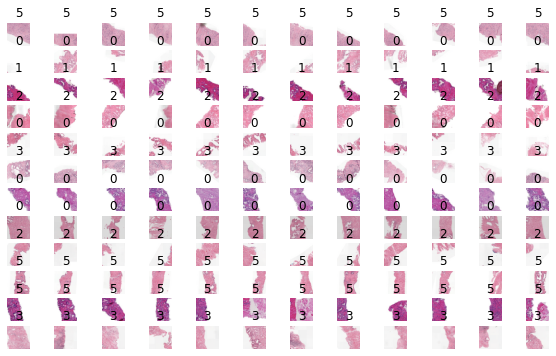

CPU times: user 2.71 s, sys: 60 ms, total: 2.77 s
Wall time: 2.65 s


array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [9]:
%%time
Xt, yt = train_datagen.__getitem__(0)
print('test X: ', Xt.shape)
print('test y: ', yt.shape)
fig, axes = plt.subplots(figsize=(10, 6), nrows=BATCH_SIZE, ncols=SEQ_LEN)
for j in range(BATCH_SIZE):
    for i in range(SEQ_LEN):
        axes[j, i].imshow(Xt[j][i])
        axes[j, i].axis('off')
        axes[j, i].set_title(np.argmax(yt[j, ]))
plt.show()
yt

In [10]:
bottleneck = efn.EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
model = Sequential()
if True:
    bottleneck = Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
    model.add(TimeDistributed(bottleneck, input_shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(GlobalMaxPooling3D())
    model.add(BatchNormalization())
    model.add(Dropout(.4))
    model.add(Dense(512, activation='Mish'))
    model.add(BatchNormalization())
    model.add(Dropout(.4))
    model.add(Dense(128, activation='Mish'))
else:
    model.add(TimeDistributed(bottleneck, input_shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(LSTM(256))
    model.add(BatchNormalization())
    model.add(Dropout(.4))
    model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(.4))
model.add(Dense(6, activation='softmax'))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 12, 4, 4, 1280)    4049564   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 4, 4, 1280)    5120      
_________________________________________________________________
global_max_pooling3d (Global (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2

In [12]:
def freeze_layers(name):
    for layer in model.layers:
        if name in layer.name:
            layer.trainable = False
        print(layer.name, layer.trainable)
def qw_kappa_score(y_true, y_pred): 
    y_true=tf.math.argmax(y_true, axis=1)
    y_pred=tf.math.argmax(y_pred, axis=1)
    def sklearn_qwk(y_true, y_pred) -> np.float64:
        return cohen_kappa_score(y_true, y_pred, weights='quadratic')
    return tf.compat.v1.py_func(sklearn_qwk, (y_true, y_pred), tf.double)

In [13]:
#freeze_layers(name='time_distributed')
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-3),
    metrics=['categorical_accuracy', qw_kappa_score]
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [14]:
%%time
model_file = '{}/model_{}.h5'.format(MODELS_PATH, MDL_VERSION)
if False:
    model = load_model(model_file)
    print('model loaded')
else:
    print('train from scratch')
EPOCHS = 100
earlystopper = EarlyStopping(
    monitor='val_qw_kappa_score', 
    patience=20, 
    verbose=1,
    mode='max'
)
modelsaver = ModelCheckpoint(
    model_file, 
    monitor='val_qw_kappa_score', 
    verbose=1, 
    save_best_only=True,
    mode='max'
)
lrreducer = ReduceLROnPlateau(
    monitor='val_qw_kappa_score',
    factor=.1,
    patience=10,
    verbose=1,
    min_lr=1e-6
)
history = model.fit_generator(
    train_datagen,
    validation_data=val_datagen,
    class_weight=class_weights,
    callbacks=[earlystopper, modelsaver, lrreducer],
    epochs=EPOCHS,
    verbose=1
)

train from scratch
Epoch 1/100
706/707 [============================>.] - ETA: 0s - loss: 3.2304 - categorical_accuracy: 0.2900 - qw_kappa_score: 0.3266
Epoch 00001: val_qw_kappa_score improved from -inf to 0.54810, saving model to ./keras_models/model_v2.h5
707/707 [==============================] - 479s 678ms/step - loss: 3.2295 - categorical_accuracy: 0.2900 - qw_kappa_score: 0.3267 - val_loss: 1.5444 - val_categorical_accuracy: 0.3710 - val_qw_kappa_score: 0.5481
Epoch 2/100
706/707 [============================>.] - ETA: 0s - loss: 2.6136 - categorical_accuracy: 0.3784 - qw_kappa_score: 0.5087
Epoch 00002: val_qw_kappa_score improved from 0.54810 to 0.55360, saving model to ./keras_models/model_v2.h5
707/707 [==============================] - 474s 671ms/step - loss: 2.6121 - categorical_accuracy: 0.3786 - qw_kappa_score: 0.5091 - val_loss: 1.4264 - val_categorical_accuracy: 0.4143 - val_qw_kappa_score: 0.5536
Epoch 3/100
706/707 [============================>.] - ETA: 0s - loss: 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



706/707 [============================>.] - ETA: 0s - loss: 2.2121 - categorical_accuracy: 0.4921 - qw_kappa_score: 0.6329
Epoch 00009: val_qw_kappa_score did not improve from 0.67129
707/707 [==============================] - 475s 672ms/step - loss: 2.2110 - categorical_accuracy: 0.4925 - qw_kappa_score: 0.6333 - val_loss: 1.2659 - val_categorical_accuracy: 0.5127 - val_qw_kappa_score: 0.6262
Epoch 10/100
706/707 [============================>.] - ETA: 0s - loss: 2.1936 - categorical_accuracy: 0.4927 - qw_kappa_score: 0.6411
Epoch 00010: val_qw_kappa_score did not improve from 0.67129
707/707 [==============================] - 474s 671ms/step - loss: 2.1952 - categorical_accuracy: 0.4926 - qw_kappa_score: 0.6406 - val_loss: 1.3074 - val_categorical_accuracy: 0.4896 - val_qw_kappa_score: 0.6355
Epoch 11/100
706/707 [============================>.] - ETA: 0s - loss: 2.1894 - categorical_accuracy: 0.4956 - qw_kappa_score: 0.6432
Epoch 00011: val_qw_kappa_score did not improve from 0.67129

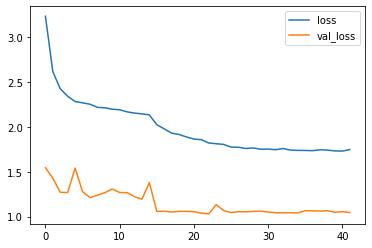

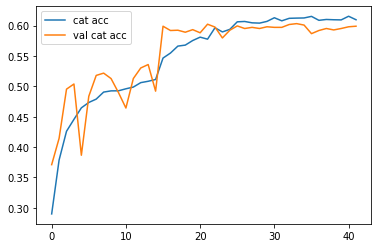

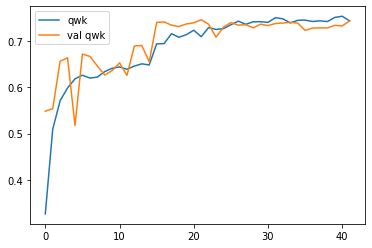

In [15]:
history_file = '{}/history_{}.txt'.format(MODELS_PATH, MDL_VERSION)
dict_to_save = {}
for k, v in history.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)
ep_max = EPOCHS
plt.plot(history.history['loss'][:ep_max], label='loss')
plt.plot(history.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['categorical_accuracy'][:ep_max], label='cat acc')
plt.plot(history.history['val_categorical_accuracy'][:ep_max], label='val cat acc')
plt.legend()
plt.show()
plt.plot(history.history['qw_kappa_score'][:ep_max], label='qwk')
plt.plot(history.history['val_qw_kappa_score'][:ep_max], label='val qwk')
plt.legend()
plt.show()

In [10]:
%%time
model_file = '{}/model_{}.h5'.format(MODELS_PATH, MDL_VERSION)
model = load_model(model_file, custom_objects={'qw_kappa_score': qw_kappa_score})
print('model loaded:', model_file)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
model loaded: ./models/model_v2.h5
CPU times: user 23.6 s, sys: 496 ms, total: 24.1 s
Wall time: 23.9 s


In [16]:
%%time
X_score = X_val.copy()
val_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_score, 
    batch_size=1,
    mode='predict', 
    shuffle=False, 
    aug=None,
    tiff=TIFF,
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)
preds = model.predict_generator(val_datagen)

CPU times: user 2min 4s, sys: 1.79 s, total: 2min 6s
Wall time: 1min 35s


In [17]:
y_true = X_score['isup_grade'].values
y_pred = np.argmax(preds, axis=1)
print('quadratic cappa score:', cohen_kappa_score(y_true, y_pred, weights='quadratic'))
print('confusion matrix:\n', confusion_matrix(y_true, y_pred))

quadratic cappa score: 0.769057077255526
confusion matrix:
 [[517  31   4   6  13   8]
 [121 276  88  23  14  11]
 [ 23  63 103  54  17   9]
 [ 17  15  30 102  42  42]
 [ 23  10  11  38 119  49]
 [ 13   2   1  33  41 155]]


In [ ]:
from tensorflow.keras.utils import get_custom_objects
class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'
def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))
get_custom_objects().update({'Mish': Mish(mish)})

In [ ]:
def tf_cohen_kappa(y_true, y_pred, num_classes=6, weights=None, metrics_collections=None, updates_collections=None, name=None):
    y_true=tf.math.argmax(y_true, axis=1)
    y_pred=tf.math.argmax(y_pred, axis=1)
    kappa, update_op = tf.contrib.metrics.cohen_kappa(
        y_true, y_pred, num_classes, weights, metrics_collections, updates_collections, name
    )
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([update_op]):
        kappa = tf.identity(kappa)
    return kappa
def tf_cohen_kappa_loss(num_classes, weights=None, metrics_collections=None, updates_collections=None, name=None):
    def cohen_kappa(y_true, y_pred):
        return -tf_cohen_kappa(y_true, y_pred, num_classes, weights, metrics_collections, updates_collections, name)
    return cohen_kappa
def quadratic_kappa_coefficient(y_true, y_pred):
    y_true = K.cast(y_true, "float32")
    n_classes = K.cast(y_pred.shape[-1], "float32")
    weights = K.arange(0, n_classes, dtype="float32") / (n_classes - 1)
    weights = (weights - K.expand_dims(weights, -1)) ** 2
    hist_true = K.sum(y_true, axis=0)
    hist_pred = K.sum(y_pred, axis=0)
    E = K.expand_dims(hist_true, axis=-1) * hist_pred
    E = E / K.sum(E, keepdims=False)
    O = K.transpose(K.transpose(y_true) @ y_pred)  # confusion matrix
    O = O / K.sum(O)
    num = weights * O
    den = weights * E
    QWK = (1 - K.sum(num) / K.sum(den))
    return QWK
def quadratic_kappa_loss(scale=2.0):
    def _quadratic_kappa_loss(y_true, y_pred):
        QWK = quadratic_kappa_coefficient(y_true, y_pred)
        loss = -K.log(K.sigmoid(scale * QWK))
        return loss  
    return _quadratic_kappa_loss